In [ ]:
# Makes us able to collect data from Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras,lite
from keras import layers
from keras.models import Sequential


In [ ]:
batch_size = 16
img_height = 25
img_width = 13

data_dir = '/content/drive/MyDrive/cropped_rank_sorted/'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 1066 files belonging to 13 classes.
Using 853 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1066 files belonging to 13 classes.
Using 213 files for validation.


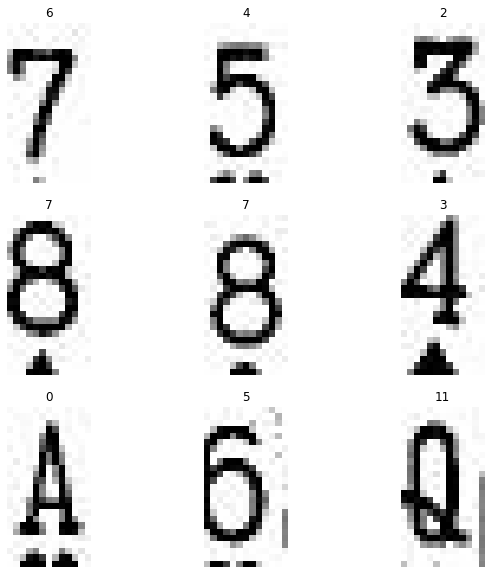

In [ ]:
#See if images are there.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [ ]:
class_names = ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king']

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 25, 13, 3)
(16,)


In [ ]:
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height,
                                  img_width,
                                  3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 25, 13, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 13, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 6, 16)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 6, 32)         4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 3, 64)         

In [ ]:
epochs = 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
54/54 [==============================] - 2s 16ms/step - loss: 2.5132 - accuracy: 0.1712 - val_loss: 2.2882 - val_accuracy: 0.4085
Epoch 2/8
54/54 [==============================] - 0s 9ms/step - loss: 1.5143 - accuracy: 0.5979 - val_loss: 0.7733 - val_accuracy: 0.7981
Epoch 3/8
54/54 [==============================] - 1s 9ms/step - loss: 0.5383 - accuracy: 0.8652 - val_loss: 0.4150 - val_accuracy: 0.8920
Epoch 4/8
54/54 [==============================] - 1s 10ms/step - loss: 0.2949 - accuracy: 0.9273 - val_loss: 0.2964 - val_accuracy: 0.9296
Epoch 5/8
54/54 [==============================] - 0s 9ms/step - loss: 0.1962 - accuracy: 0.9519 - val_loss: 0.1995 - val_accuracy: 0.9437
Epoch 6/8
54/54 [==============================] - 0s 9ms/step - loss: 0.1145 - accuracy: 0.9754 - val_loss: 0.1685 - val_accuracy: 0.9577
Epoch 7/8
54/54 [==============================] - 0s 9ms/step - loss: 0.0913 - accuracy: 0.9812 - val_loss: 0.1561 - val_accuracy: 0.9484
Epoch 8/8
54/54 [========

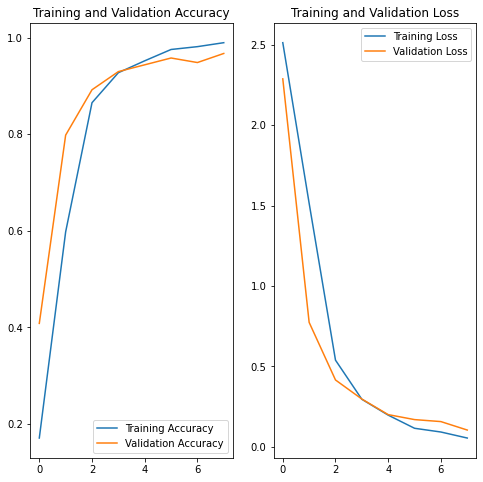

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:

files_to_guess = ['/content/drive/MyDrive/test_images_rank/ace.jpg',
                  '/content/drive/MyDrive/test_images_rank/two.jpg',
                  '/content/drive/MyDrive/test_images_rank/two_1.jpg',
                  '/content/drive/MyDrive/test_images_rank/two_2.jpg',
                  # '/content/drive/MyDrive/test_images_rank/three.jpg',
                  # '/content/drive/MyDrive/test_images_rank/four.jpg',
                 # '/content/drive/MyDrive/test_images_rank/five.jpg',
                  '/content/drive/MyDrive/test_images_rank/six.jpg',
                  # '/content/drive/MyDrive/test_images_rank/seven.jpg',
                  # '/content/drive/MyDrive/test_images_rank/eight.jpg',
                  # '/content/drive/MyDrive/test_images_rank/nine.jpg',
                  # '/content/drive/MyDrive/test_images_rank/ten.jpg',
                  # '/content/drive/MyDrive/test_images_rank/jack.jpg',
                  # '/content/drive/MyDrive/test_images_rank/queen.jpg',
                  # '/content/drive/MyDrive/test_images_rank/king.jpg'
                  ]

for path in files_to_guess:
  img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  print(path)
  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )


/content/drive/MyDrive/test_images_rank/ace.jpg
This image most likely belongs to ace with a 95.03 percent confidence.
/content/drive/MyDrive/test_images_rank/two.jpg
This image most likely belongs to four with a 28.25 percent confidence.
/content/drive/MyDrive/test_images_rank/two_1.jpg
This image most likely belongs to two with a 87.45 percent confidence.
/content/drive/MyDrive/test_images_rank/two_2.jpg
This image most likely belongs to two with a 53.86 percent confidence.
/content/drive/MyDrive/test_images_rank/six.jpg
This image most likely belongs to six with a 97.20 percent confidence.


In [ ]:
model.save(r"/content/drive/MyDrive/CDIO F22/ML modeller/rank_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CDIO F22/ML modeller/rank_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CDIO F22/ML modeller/rank_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(r"/content/drive/MyDrive/CDIO F22/ML modeller/rank_model")
tflite_model = converter.convert()

with open(r"/content/drive/MyDrive/CDIO F22/ML modeller/tflite_rank_model.tflite", 'wb') as f:
  f.write(tflite_model)



In [ ]:
  keras_file = "/content/drive/MyDrive/CDIO F22/ML modeller/keras/rank.h5"
  tf.keras.models.save_model(model,keras_file)
  converter = lite.TFLiteConverter.from_keras_model(model)
  tfmodel = converter.convert()

  open("/content/drive/MyDrive/CDIO F22/ML modeller/keras/rank.tflite","wb").write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp8bl7z2yj/assets


INFO:tensorflow:Assets written to: /tmp/tmp8bl7z2yj/assets


203428